In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
from numpy.random import seed
seed(42)
import random
random.seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

import os
import sys
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense
import time
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error
from math import sqrt


#define function to turn grayscale into rgb
def to_rgb(im):
    '''
    # I think this will be slow
    w, h = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im
    ret[:, :, 1] = im
    ret[:, :, 2] = im
    return ret
    '''
    # maya - this should run faster
    #ret = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
target = 'sexual_interest'
target = ['trustworthiness', "sexual_interest", "intelligence", "confidence","happiness"]

#set constants
limit = 5000 #with how many pictures do I want to experiment
# maya - I think you can choose smaller image size to start with. smaller the input, faster the process
# I also think Resnet accepts various size inputs, you can try giving it actual size images without deformation
height = 224
width = 224
cv_folds = 4
batchsize = 32
preprocess = False
nr_epochs = 5
rescaling = True #True False
lrr = 0.001 #0.01 0.005 0.001 0.0005 0.0001
unfreeze = 176 #-8 -5 -2 176

#read labels
labels = pd.read_csv('../input/labels/labels.csv', header = 'infer')
print(labels['player.photo'][0:3])
Y = np.array(labels[target][0:limit])
labels['file'] = "../input/resized-images/resized_images/resized_images/" + labels['player.photo']

0     0_the gap666.jpg
1    1_topshop1716.jpg
2    10_topshop894.jpg
Name: player.photo, dtype: object


In [3]:
if preprocess:
    # read images
    X = np.empty(shape=(limit, height, width, 3), dtype='uint8')
    images = [np.array(Image.open("images/" + fname)) for fname in labels['player.photo'][0:limit]]

    #bring into same format
    for i, image in enumerate(images):
        if len(image.shape) == 2:
            special_case = labels['player.photo'][i]
            resized_img = cv2.imread("images/" + special_case, cv2.IMREAD_GRAYSCALE)
            resized_img = Image.fromarray(resized_img)
            resized_img = resized_img.resize((224,224))
            resized_img = np.array(resized_img)
            resized_img = to_rgb(resized_img)
            # plt.imshow(Image.fromarray(resized_img, mode= 'RGB'))
            # plt.show()


        elif image.shape[2] == 4 or image.shape[2] == 3:
            resized_img = Image.fromarray(image[...,:3])
            resized_img = resized_img.resize((height,width))
            resized_img = np.array(resized_img)

        elif image.shape[2] == 2:
            image = np.array(image[...,0], dtype= 'uint8')
            resized_img = Image.fromarray(image)
            resized_img = resized_img.resize((224,224))
            resized_img = np.array(resized_img)
            resized_img = to_rgb(resized_img)

        else:
            print("There are other formats!")
            print(image.shape)
            sys.exit()

        X[i] = resized_img

    np.save(r"../input/preprocessed images/preprocessed_data.npy", X)

else:
    X = np.load(r"../input/preprocessed-images/preprocessed_data.npy")
    X = X[0:limit]



In [4]:
#load resnet50
resnet = ResNet50(include_top=False, pooling='avg', weights = 'imagenet')
for layer in resnet.layers[:unfreeze]:
    layer.trainable = False
model = Sequential()
model.add(resnet)

#add linear last layer
model.add(Dense(5, activation='linear'))

#compile model
# maya - here I do propose to do a grid-search to find the best fine-tuning parameters
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=lrr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['mse'])
model.summary()

94658560/94653016 [==============================] - 3s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [5]:
#data augmentation
if rescaling:
    datagen = ImageDataGenerator(rescale = 1./255.,
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.25, horizontal_flip=True, vertical_flip=False)
if not rescaling:
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.25, horizontal_flip=True, vertical_flip=False)

In [6]:
#this code is to check whether the pictures in X and in the labels dataframe are in the same order (important to avoid information leak below)

# sample = 245
# sample_array = np.array([sample])
# for x, y in datagen.flow_from_dataframe(dataframe=labels.iloc[sample_array], directory="../input/resized-images/resized_images/resized_images/", 
#                                                   x_col="player.photo", y_col="sexual_interest", has_ext=True, 
#                                                   class_mode="other", target_size=(224, 224), 
#                                                   batch_size=1):
#     test = np.array(x[0], dtype = 'uint8')
#     plt.imshow(Image.fromarray(test, mode= 'RGB'))
#     plt.show()
#     break

# test = np.array(X[sample], dtype = 'uint8')
# plt.imshow(Image.fromarray(test, mode= 'RGB'))
# plt.show()

In [7]:
#set up cross-validation
kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

trustworthiness_val_rmse = []
confidence_val_rmse = []
sexual_interest_val_rmse = []
intelligence_val_rmse = []
happiness_val_rmse = []
trustworthiness_cors = []
confidence_cors = []
sexual_interest_cors = []
intelligence_cors = []
happiness_cors = []

for train, test in kfold.split(labels):
    
    
    history = model.fit_generator(datagen.flow_from_dataframe(dataframe=labels.iloc[train], directory="../input/resized-images/resized_images/resized_images/", 
                                                  x_col="player.photo", y_col=target, has_ext=True, 
                                                  class_mode="other", target_size=(224, 224), 
                                                  batch_size=batchsize), steps_per_epoch=labels.iloc[train].shape[0] / batchsize, epochs=nr_epochs, validation_data=(X[test], labels.iloc[test][target])) 
    
    ytrue = labels.iloc[test][target]
    ypreds = model.predict(X[test])
    
    trustworthiness_cor = np.corrcoef(ypreds[:,0], ytrue.iloc[:,0])
    trustworthiness_val_mse = mean_squared_error(ypreds[:,0], ytrue.iloc[:,0])
    trustworthiness_rmse = sqrt(trustworthiness_val_mse)
    trustworthiness_val_rmse.append(trustworthiness_rmse)

    sexual_interest_cor = np.corrcoef(ypreds[:,1], ytrue.iloc[:,1])
    sexual_interest_val_mse = mean_squared_error(ypreds[:,1], ytrue.iloc[:,1])
    sexual_interest_rmse = sqrt(sexual_interest_val_mse)
    sexual_interest_val_rmse.append(sexual_interest_rmse)

    intelligence_cor = np.corrcoef(ypreds[:,2], ytrue.iloc[:,2])
    intelligence_val_mse = mean_squared_error(ypreds[:,2], ytrue.iloc[:,2])
    intelligence_rmse = sqrt(intelligence_val_mse)
    intelligence_val_rmse.append(intelligence_rmse)

    confidence_cor = np.corrcoef(ypreds[:,3], ytrue.iloc[:,3])
    confidence_val_mse = mean_squared_error(ypreds[:,3], ytrue.iloc[:,3])
    confidence_rmse = sqrt(confidence_val_mse)
    confidence_val_rmse.append(confidence_rmse)

    happiness_cor = np.corrcoef(ypreds[:,4], ytrue.iloc[:,4])
    happiness_val_mse = mean_squared_error(ypreds[:,4], ytrue.iloc[:,4])
    happiness_rmse = sqrt(happiness_val_mse)
    happiness_val_rmse.append(happiness_rmse)
    
    confidence_cors.append(confidence_cor[0,1])
    sexual_interest_cors.append(sexual_interest_cor[0,1])
    happiness_cors.append(happiness_cor[0,1])
    intelligence_cors.append(intelligence_cor[0,1])
    trustworthiness_cors.append(trustworthiness_cor[0,1])



Found 3750 validated image filenames.
Epoch 1/5
118/117 [==============================] - 48s 408ms/step - loss: 2.8882 - mean_squared_error: 2.8882 - val_loss: 3.6240 - val_mean_squared_error: 3.6240
Epoch 2/5
118/117 [==============================] - 40s 340ms/step - loss: 1.0752 - mean_squared_error: 1.0752 - val_loss: 3.3219 - val_mean_squared_error: 3.3219
Epoch 3/5
118/117 [==============================] - 41s 346ms/step - loss: 0.8932 - mean_squared_error: 0.8932 - val_loss: 2.4584 - val_mean_squared_error: 2.4584
Epoch 4/5
118/117 [==============================] - 41s 346ms/step - loss: 0.7618 - mean_squared_error: 0.7618 - val_loss: 2.0716 - val_mean_squared_error: 2.0716
Epoch 5/5
118/117 [==============================] - 41s 346ms/step - loss: 0.6929 - mean_squared_error: 0.6929 - val_loss: 1.8040 - val_mean_squared_error: 1.8040
Found 3750 validated image filenames.
Epoch 1/5
118/117 [==============================] - 44s 374ms/step - loss: 0.6625 - mean_squared_error:



dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


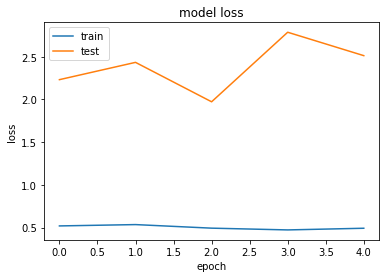

In [8]:
# history = model
print("\n")
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
print(confidence_cors)


[0.33988067323483123, 0.3989847263216669, 0.382501339965939, 0.4475143920979739]


In [10]:
my_submission = pd.DataFrame({'sexual': np.median(sexual_interest_cors),'confident': np.median(confidence_cors),'happy': np.median(happiness_cors), 'intel': np.median(intelligence_cors), 'trust': np.median(trustworthiness_cors)}, index=[0])
my_submission.to_csv(str(lrr) + str(lrr) + str(unfreeze) + '_submission.csv', index=False)